In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import re
import nltk
from nltk import corpus,tokenize
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('vaderlexicon')
nltk.download('wordnet')
from spellchecker import SpellChecker
from nltk.stem import PorterStemmer,WordNetLemmatizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer 

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer #BOW,Tfidf
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess  # For text preprocessing

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV

from sklearn.naive_bayes import GaussianNB,BernoulliNB,MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

from sklearn.decomposition import PCA

from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Embedding,SimpleRNN,LSTM,GRU,Dropout,Dense,Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\achyu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Error loading vaderlexicon: Package 'vaderlexicon' not
[nltk_data]     found in index
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\achyu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import pandas as pd

# Sample data
data = {
    "text": [
        "I love this product!", "This is the worst experience ever.", "It's okay, not great but not bad.",
        "Absolutely fantastic service!", "I hate waiting in lines.", "I'm feeling neutral about this.",
        "Best purchase I've made!", "Terrible quality, very disappointed.", "It was an average movie.",
        "I would highly recommend this!", "Not worth the money.", "I'm indifferent to this brand.",
        "This is amazing!", "The food was awful.", "Just so-so.",
        "I'm very satisfied with my order.", "This is a disaster!", "It was fine, nothing special.",
        "I adore this place!", "The staff were rude.", "It was just okay.",
        # ... (add more records to reach 200)
    ] * 10,  # Repeat to create 200 records
    "sentiment": [
        "positive", "negative", "neutral",
        "positive", "negative", "neutral",
        "positive", "negative", "neutral",
        "positive", "negative", "neutral",
        "positive", "negative", "neutral",
        "positive", "negative", "neutral",
        "positive", "negative", "neutral"
        # ... (add more labels to match the texts)
    ] * 10  # Repeat to create 200 records
}

# Create DataFrame
df = pd.DataFrame(data)

# Shuffle the DataFrame
df = df.sample(frac=1).reset_index(drop=True)

# Display the first few rows of the DataFrame
print(df.head())
print(df.info())


                                   text sentiment
0  Terrible quality, very disappointed.  negative
1       I'm feeling neutral about this.   neutral
2                   I adore this place!  positive
3                  I love this product!  positive
4         Absolutely fantastic service!  positive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       210 non-null    object
 1   sentiment  210 non-null    object
dtypes: object(2)
memory usage: 3.4+ KB
None


## 1. Text Preprocessing

In [3]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]','',text)
    return text

df['cleaned_text'] = df['text'].apply(preprocess_text)
df.head(5)

,text,sentiment,cleaned_text
0,"Terrible quality, very disappointed.",negative,terrible quality very disappointed
1,I'm feeling neutral about this.,neutral,im feeling neutral about this
2,I adore this place!,positive,i adore this place
3,I love this product!,positive,i love this product
4,Absolutely fantastic service!,positive,absolutely fantastic service


In [4]:
df['sentiment'] = df['sentiment'].astype('category')
df['sentiment'] = df['sentiment'].cat.codes

In [5]:
df.head(5)

,text,sentiment,cleaned_text
0,"Terrible quality, very disappointed.",0,terrible quality very disappointed
1,I'm feeling neutral about this.,1,im feeling neutral about this
2,I adore this place!,2,i adore this place
3,I love this product!,2,i love this product
4,Absolutely fantastic service!,2,absolutely fantastic service


In [6]:
x = df['cleaned_text']
y = df['sentiment']

In [7]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size =0.2,random_state = 42)

In [8]:
print(x_train.head())
print(x_test.head())

150    terrible quality very disappointed
96                    not worth the money
200          absolutely fantastic service
68                     this is a disaster
156        its okay not great but not bad
Name: cleaned_text, dtype: object
30            it was an average movie
172           i hate waiting in lines
84     its okay not great but not bad
199               the staff were rude
60            it was an average movie
Name: cleaned_text, dtype: object


In [9]:
print("Number of empty entries in x_train:", x_train.isnull().sum())
print("Number of empty entries in x_test:", x_test.isnull().sum())

Number of empty entries in x_train: 0
Number of empty entries in x_test: 0


In [10]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (168,)
y_train shape: (168,)
x_test shape: (42,)
y_test shape: (42,)


# BOW

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
cv_xtrain = cv.fit_transform(x_train).toarray()
cv_xtest = cv.transform(x_test).toarray()

In [12]:
print(cv_xtrain.shape)
print(cv_xtest.shape)

(168, 64)
(42, 64)


# Tfidf

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
tfidf_xtrain = tfidf.fit_transform(x_train).toarray()
tfidf_xtest = tfidf.transform(x_test).toarray()

In [14]:
print(tfidf_xtrain.shape)
print(tfidf_xtest.shape)

(168, 64)
(42, 64)


In [15]:
def train_evaluate_model(model,x_train,x_test,y_train,y_test):
    model.fit(x_train,y_train)
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
    print(f"Training_Accuraccy_score:{accuracy_score(y_train,y_pred_train)}")
    print(f"Testing_Accuracy_score:{accuracy_score(y_test,y_pred_test)}")
    print(f"Training_Classification_Report:{classification_report(y_train,y_pred_train)}")
    print(f"Testing_Classification_Report:{classification_report(y_test,y_pred_test)}")
    return model

# Usign BOW

## Logistic Regression(OVR)

In [16]:
lr_ovr =LogisticRegression(multi_class = 'ovr',solver = 'liblinear',random_state = 42)

In [17]:
lr_model = train_evaluate_model(lr_ovr,cv_xtrain,cv_xtest,y_train,y_test)
lr_model

Training_Accuraccy_score:1.0
Testing_Accuracy_score:1.0
Training_Classification_Report:              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       1.00      1.00      1.00        51
           2       1.00      1.00      1.00        60

    accuracy                           1.00       168
   macro avg       1.00      1.00      1.00       168
weighted avg       1.00      1.00      1.00       168

Testing_Classification_Report:              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        10

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42
weighted avg       1.00      1.00      1.00        42



LogisticRegression(multi_class='ovr', random_state=42, solver='liblinear')

# Logistic Regression (Softmax)

In [19]:
lr_softmax = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs',random_state = 42)

In [20]:
lr_softmax_model = train_evaluate_model(lr_softmax,cv_xtrain,cv_xtest,y_train,y_test)
lr_softmax_model

Training_Accuraccy_score:1.0
Testing_Accuracy_score:1.0
Training_Classification_Report:              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       1.00      1.00      1.00        51
           2       1.00      1.00      1.00        60

    accuracy                           1.00       168
   macro avg       1.00      1.00      1.00       168
weighted avg       1.00      1.00      1.00       168

Testing_Classification_Report:              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        10

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42
weighted avg       1.00      1.00      1.00        42



LogisticRegression(multi_class='multinomial', random_state=42)

# USing Tfidf

In [21]:
lr_ovr_tfidf =LogisticRegression(multi_class = 'ovr',solver = 'liblinear',random_state = 42)

In [22]:
lr_model_ovr_tfidf = train_evaluate_model(lr_ovr,tfidf_xtrain,tfidf_xtest,y_train,y_test)
lr_model_ovr_tfidf

Training_Accuraccy_score:1.0
Testing_Accuracy_score:1.0
Training_Classification_Report:              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       1.00      1.00      1.00        51
           2       1.00      1.00      1.00        60

    accuracy                           1.00       168
   macro avg       1.00      1.00      1.00       168
weighted avg       1.00      1.00      1.00       168

Testing_Classification_Report:              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        10

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42
weighted avg       1.00      1.00      1.00        42



LogisticRegression(multi_class='ovr', random_state=42, solver='liblinear')

## Using OVR

## Using Softmax

In [23]:
lr_softmax_tfidf = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs',random_state = 42)

In [24]:
lr_softmax_model_tfidf = train_evaluate_model(lr_softmax,tfidf_xtrain,tfidf_xtest,y_train,y_test)
lr_softmax_model_tfidf

Training_Accuraccy_score:1.0
Testing_Accuracy_score:1.0
Training_Classification_Report:              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       1.00      1.00      1.00        51
           2       1.00      1.00      1.00        60

    accuracy                           1.00       168
   macro avg       1.00      1.00      1.00       168
weighted avg       1.00      1.00      1.00       168

Testing_Classification_Report:              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        10

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42
weighted avg       1.00      1.00      1.00        42



LogisticRegression(multi_class='multinomial', random_state=42)

# Naive Bayes

## Multinomial Naive Bayes

In [25]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
Multinomial_nb = train_evaluate_model(mnb,tfidf_xtrain,tfidf_xtest,y_train,y_test)
Multinomial_nb

Training_Accuraccy_score:1.0
Testing_Accuracy_score:1.0
Training_Classification_Report:              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       1.00      1.00      1.00        51
           2       1.00      1.00      1.00        60

    accuracy                           1.00       168
   macro avg       1.00      1.00      1.00       168
weighted avg       1.00      1.00      1.00       168

Testing_Classification_Report:              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        10

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42
weighted avg       1.00      1.00      1.00        42



MultinomialNB()

## Binomial Naive Bayes

In [26]:
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
Bernoulli_NB = train_evaluate_model(bnb,tfidf_xtrain,tfidf_xtest,y_train,y_test)
Bernoulli_NB

Training_Accuraccy_score:1.0
Testing_Accuracy_score:1.0
Training_Classification_Report:              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       1.00      1.00      1.00        51
           2       1.00      1.00      1.00        60

    accuracy                           1.00       168
   macro avg       1.00      1.00      1.00       168
weighted avg       1.00      1.00      1.00       168

Testing_Classification_Report:              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        10

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42
weighted avg       1.00      1.00      1.00        42



BernoulliNB()

## Gaussian Naive Bayes

In [27]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
Gaussian_NB = train_evaluate_model(gnb,tfidf_xtrain,tfidf_xtest,y_train,y_test)
Gaussian_NB

Training_Accuraccy_score:1.0
Testing_Accuracy_score:1.0
Training_Classification_Report:              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       1.00      1.00      1.00        51
           2       1.00      1.00      1.00        60

    accuracy                           1.00       168
   macro avg       1.00      1.00      1.00       168
weighted avg       1.00      1.00      1.00       168

Testing_Classification_Report:              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        10

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42
weighted avg       1.00      1.00      1.00        42



GaussianNB()

# Support Vectors Machines

In [28]:
from sklearn.svm import SVC

svc  = SVC()

In [29]:
param_grid = {
    'C':[0.1,1,5,10],
    'kernel':['linear','rbf','poly','sigmoid'],
    'gamma' : ['scale','auto']}
    

In [30]:
from sklearn.model_selection import GridSearchCV

svc_grid_search = GridSearchCV(svc,param_grid = param_grid,cv = 5,scoring = 'accuracy',verbose = 1)
svc_grid_search

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 5, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='accuracy', verbose=1)

In [31]:
svc_grid_search.fit(tfidf_xtrain,y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 5, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='accuracy', verbose=1)

In [32]:
print("Best Parameters:", svc_grid_search.best_params_)

Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}


In [33]:
svc_grid_search_best_model = svc_grid_search.best_estimator_

In [34]:
svc_tfidf = train_evaluate_model(svc_grid_search_best_model,tfidf_xtrain,tfidf_xtest,y_train,y_test)
svc_tfidf

Training_Accuraccy_score:1.0
Testing_Accuracy_score:1.0
Training_Classification_Report:              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       1.00      1.00      1.00        51
           2       1.00      1.00      1.00        60

    accuracy                           1.00       168
   macro avg       1.00      1.00      1.00       168
weighted avg       1.00      1.00      1.00       168

Testing_Classification_Report:              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        10

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42
weighted avg       1.00      1.00      1.00        42



SVC(C=0.1, kernel='poly')

# KNN

In [35]:
from sklearn.neighbors import KNeighborsClassifier

In [36]:
knn = KNeighborsClassifier(n_neighbors = 5)

In [37]:
knn_tfidf = train_evaluate_model(knn,tfidf_xtrain,tfidf_xtest,y_train,y_test)
knn_tfidf

Training_Accuraccy_score:1.0
Testing_Accuracy_score:1.0
Training_Classification_Report:              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       1.00      1.00      1.00        51
           2       1.00      1.00      1.00        60

    accuracy                           1.00       168
   macro avg       1.00      1.00      1.00       168
weighted avg       1.00      1.00      1.00       168

Testing_Classification_Report:              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        10

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42
weighted avg       1.00      1.00      1.00        42



KNeighborsClassifier()

# Decision Tree

In [38]:
from sklearn.tree import DecisionTreeClassifier

In [39]:
dt_tfidf = DecisionTreeClassifier()

In [40]:
param_grid_dt = {
    'criterion' : ['gini','entropy'],
    'max_depth':[2,5,10,15],
    'min_samples_split':[1,2,5,10],
    'min_samples_leaf':[1,2,3,4],
    'random_state':[42]}

In [41]:
dt_grid_search = GridSearchCV(dt_tfidf,param_grid = param_grid_dt,cv = 5,scoring = 'accuracy')
dt_grid_search

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 5, 10, 15],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [1, 2, 5, 10],
                         'random_state': [42]},
             scoring='accuracy')

In [42]:
dt_grid_search.fit(tfidf_xtrain,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 5, 10, 15],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [1, 2, 5, 10],
                         'random_state': [42]},
             scoring='accuracy')

In [43]:
print("Best Parameters:",dt_grid_search.best_params_)

Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42}


In [44]:
dt_grid_search_best_parms = dt_grid_search.best_estimator_

In [45]:
dt_tfidf = train_evaluate_model(dt_grid_search_best_parms,tfidf_xtrain,tfidf_xtest,y_train,y_test)
dt_tfidf

Training_Accuraccy_score:1.0
Testing_Accuracy_score:1.0
Training_Classification_Report:              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       1.00      1.00      1.00        51
           2       1.00      1.00      1.00        60

    accuracy                           1.00       168
   macro avg       1.00      1.00      1.00       168
weighted avg       1.00      1.00      1.00       168

Testing_Classification_Report:              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        10

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42
weighted avg       1.00      1.00      1.00        42



DecisionTreeClassifier(max_depth=10, random_state=42)

# Random Forest

In [46]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state = 42)

In [47]:
rf_tfidf = train_evaluate_model(rf,tfidf_xtrain,tfidf_xtest,y_train,y_test)
rf_tfidf

Training_Accuraccy_score:1.0
Testing_Accuracy_score:1.0
Training_Classification_Report:              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       1.00      1.00      1.00        51
           2       1.00      1.00      1.00        60

    accuracy                           1.00       168
   macro avg       1.00      1.00      1.00       168
weighted avg       1.00      1.00      1.00       168

Testing_Classification_Report:              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        10

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42
weighted avg       1.00      1.00      1.00        42



RandomForestClassifier(random_state=42)

# AdaBoost

In [48]:
from sklearn.ensemble import AdaBoostClassifier

ada_boost_tfidf = AdaBoostClassifier()

In [49]:
ad_tfidf = train_evaluate_model(ada_boost_tfidf,tfidf_xtrain,tfidf_xtest,y_train,y_test)
ad_tfidf

Training_Accuraccy_score:0.8452380952380952
Testing_Accuracy_score:0.9047619047619048
Training_Classification_Report:              precision    recall  f1-score   support

           0       1.00      0.54      0.70        57
           1       1.00      1.00      1.00        51
           2       0.70      1.00      0.82        60

    accuracy                           0.85       168
   macro avg       0.90      0.85      0.84       168
weighted avg       0.89      0.85      0.84       168

Testing_Classification_Report:              precision    recall  f1-score   support

           0       1.00      0.69      0.82        13
           1       1.00      1.00      1.00        19
           2       0.71      1.00      0.83        10

    accuracy                           0.90        42
   macro avg       0.90      0.90      0.88        42
weighted avg       0.93      0.90      0.90        42



AdaBoostClassifier()

# Gradient Boosting

In [50]:
from sklearn.ensemble import GradientBoostingClassifier

In [51]:
gd_model_tfidf = GradientBoostingClassifier(n_estimators = 50,learning_rate =0.1,max_depth = 3,random_state =42)

In [52]:
gd_tfidf = train_evaluate_model(gd_model_tfidf,tfidf_xtrain,tfidf_xtest,y_train,y_test)
gd_tfidf

Training_Accuraccy_score:1.0
Testing_Accuracy_score:1.0
Training_Classification_Report:              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       1.00      1.00      1.00        51
           2       1.00      1.00      1.00        60

    accuracy                           1.00       168
   macro avg       1.00      1.00      1.00       168
weighted avg       1.00      1.00      1.00       168

Testing_Classification_Report:              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        10

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42
weighted avg       1.00      1.00      1.00        42



GradientBoostingClassifier(n_estimators=50, random_state=42)

# XGBoost

In [53]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

In [54]:
xgboost_model = XGBClassifier()

In [55]:
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample':[0.6,0.8,1.0],
    'colsample_bytree':[0.6,0.8,1.0]}

In [56]:
random_search = RandomizedSearchCV(estimator = xgboost_model,param_distributions =param_dist,
                          n_iter =10,scoring = 'accuracy',cv = 3,verbose = 1,random_state =42)

In [57]:
random_search.fit(tfidf_xtrain,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 4, 5, 6],
                                        'n_estimators': [50, 100, 200],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='accuracy', verbose=1)

In [58]:
print("Best Parameters:",random_search.best_params_)

Best Parameters: {'subsample': 0.6, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.8}


In [59]:
xgboost_best_model = random_search.best_estimator_

In [60]:
xgboost_tfidf = train_evaluate_model(xgboost_best_model,tfidf_xtrain,tfidf_xtest,y_train,y_test)
xgboost_tfidf

Training_Accuraccy_score:1.0
Testing_Accuracy_score:1.0
Training_Classification_Report:              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       1.00      1.00      1.00        51
           2       1.00      1.00      1.00        60

    accuracy                           1.00       168
   macro avg       1.00      1.00      1.00       168
weighted avg       1.00      1.00      1.00       168

Testing_Classification_Report:              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        10

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42
weighted avg       1.00      1.00      1.00        42



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

# Word2Vec Model

In [61]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [62]:
import pandas as pd

# Sample data
data1 = {
    "text": [
        "I love this product!", "This is the worst experience ever.", "It's okay, not great but not bad.",
        "Absolutely fantastic service!", "I hate waiting in lines.", "I'm feeling neutral about this.",
        "Best purchase I've made!", "Terrible quality, very disappointed.", "It was an average movie.",
        "I would highly recommend this!", "Not worth the money.", "I'm indifferent to this brand.",
        "This is amazing!", "The food was awful.", "Just so-so.",
        "I'm very satisfied with my order.", "This is a disaster!", "It was fine, nothing special.",
        "I adore this place!", "The staff were rude.", "It was just okay.",
        # ... (add more records to reach 200)
    ] * 10,  # Repeat to create 200 records
    "sentiment": [
        "positive", "negative", "neutral",
        "positive", "negative", "neutral",
        "positive", "negative", "neutral",
        "positive", "negative", "neutral",
        "positive", "negative", "neutral",
        "positive", "negative", "neutral",
        "positive", "negative", "neutral"
        # ... (add more labels to match the texts)
    ] * 10  # Repeat to create 200 records
}

# Create DataFrame
df1 = pd.DataFrame(data1)

# Shuffle the DataFrame
df1 = df1.sample(frac=1).reset_index(drop=True)

# Display the first few rows of the DataFrame
print(df1.head())
print(df1.info())


                             text sentiment
0               It was just okay.   neutral
1        It was an average movie.   neutral
2  I'm indifferent to this brand.   neutral
3            The staff were rude.  negative
4        Best purchase I've made!  positive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       210 non-null    object
 1   sentiment  210 non-null    object
dtypes: object(2)
memory usage: 3.4+ KB
None


In [63]:
def preprocess_text(texts):
    """
    Tokenize and clean the text.
    """
    from gensim.utils import simple_preprocess
    return [simple_preprocess(doc) for doc in texts]

In [64]:
processed_corpus = preprocess_text(df['text'])

In [65]:
def vectorize_text(corpus, model):
    # Convert text to vectors by averaging the word vectors
    vectors = []
    for tokens in corpus:
        word_vecs = [model.wv[word] for word in tokens if word in model.wv]
        if word_vecs:
            vectors.append(np.mean(word_vecs, axis=0))
        else:
            # Handle empty tokens (rare but possible if all words are out-of-vocabulary)
            vectors.append(np.zeros(model.vector_size))
    return np.array(vectors)

### Skip_Gram

In [66]:
skipgram_model = Word2Vec(sentences = processed_corpus,vector_size =100,window =5,sg =1,min_count =1,
                          workers = 3,epochs =10)
# workers >1 uses parallel processing (more cpu cores will be used)                

### converting text to vectors

In [67]:
x_skipgram = vectorize_text(processed_corpus,skipgram_model)
x_skipgram

array([[-1.4169329e-03,  1.7013620e-03, -1.7783692e-04, ...,
         6.7303376e-04, -5.5092829e-04, -4.5351442e-03],
       [ 9.5072668e-05,  1.1315376e-03, -4.4641229e-03, ...,
        -1.9433289e-03,  1.7486386e-03,  2.8859731e-03],
       [ 8.9083816e-04,  2.3218703e-03,  2.7289775e-03, ...,
        -1.3322020e-03,  4.6629677e-04,  3.8247710e-04],
       ...,
       [ 9.5072668e-05,  1.1315376e-03, -4.4641229e-03, ...,
        -1.9433289e-03,  1.7486386e-03,  2.8859731e-03],
       [-4.3200734e-03,  3.9931661e-03, -5.9793945e-03, ...,
        -1.7385336e-04, -5.1099109e-04, -5.7127019e-03],
       [-1.1220225e-03,  2.5424256e-03, -5.0114077e-03, ...,
        -2.5877784e-04,  5.9655202e-03, -3.7697747e-03]], dtype=float32)

In [68]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df1['sentiment'])

In [69]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_skipgram,y,test_size =0.2,random_state =42)

In [70]:
from sklearn.svm import SVC
svc = SVC(C =0.1,gamma = 'scale',kernel = 'poly')

In [71]:
def train_evaluate_model(model,x_train,x_test,y_train,y_test):
    model.fit(x_train,y_train)
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
    print(f"Training_Accuraccy_score:{accuracy_score(y_train,y_pred_train)}")
    print(f"Testing_Accuracy_score:{accuracy_score(y_test,y_pred_test)}")
    print(f"Training_Classification_Report:{classification_report(y_train,y_pred_train)}")
    print(f"Testing_Classification_Report:{classification_report(y_test,y_pred_test)}")
    return model

In [72]:
svc_skipgram = train_evaluate_model(svc,x_train,x_test,y_train,y_test)
svc_skipgram

Training_Accuraccy_score:0.36904761904761907
Testing_Accuracy_score:0.19047619047619047
Training_Classification_Report:              precision    recall  f1-score   support

           0       0.00      0.00      0.00        55
           1       0.37      1.00      0.54        62
           2       0.00      0.00      0.00        51

    accuracy                           0.37       168
   macro avg       0.12      0.33      0.18       168
weighted avg       0.14      0.37      0.20       168

Testing_Classification_Report:              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.19      1.00      0.32         8
           2       0.00      0.00      0.00        19

    accuracy                           0.19        42
   macro avg       0.06      0.33      0.11        42
weighted avg       0.04      0.19      0.06        42



SVC(C=0.1, kernel='poly')

## CBOW

In [73]:
cbow_model = Word2Vec(sentences = processed_corpus,vector_size = 100,window = 5,sg=0,min_count =1,
                      workers =3,epochs =10)


In [74]:
x_cbow = vectorize_text(processed_corpus,cbow_model)
x_cbow

array([[-1.2158750e-03,  1.6404244e-03,  8.9031470e-05, ...,
         5.5303681e-04, -6.7446975e-04, -4.4419100e-03],
       [ 4.5882683e-04,  9.0502232e-04, -4.0996792e-03, ...,
        -1.9989025e-03,  1.6379610e-03,  2.9014170e-03],
       [ 1.1774992e-03,  2.2077828e-03,  3.0095521e-03, ...,
        -1.4760984e-03,  3.9039273e-04,  3.2204296e-04],
       ...,
       [ 4.5882683e-04,  9.0502232e-04, -4.0996792e-03, ...,
        -1.9989025e-03,  1.6379610e-03,  2.9014170e-03],
       [-4.0617427e-03,  3.7977952e-03, -5.7378230e-03, ...,
        -3.5766314e-04, -5.5261259e-04, -5.7414379e-03],
       [-6.6518423e-04,  2.1585887e-03, -4.5858799e-03, ...,
        -6.6937332e-04,  5.8622477e-03, -3.8117641e-03]], dtype=float32)

In [75]:
def vectorize_text(corpus,model):
    vectors =[]
    for tokens in corpus:
        word_vecs = [model.wv[word] for word in tokens if word in model.wv]
        if word_vecs:
            vectors.append(np.mean(word_vecs,axis =0))
        else:
            vectors.append(np.zeros(model.vector_size))
    return np.array(vectors)            
                           

In [76]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df1['sentiment'])

In [77]:
from sklearn.model_selection import train_test_split
x_train_cbow,x_test_cbow,y_train_cbow,y_test_cbow = train_test_split(x_cbow,y,test_size =0.2,random_state =42)

In [78]:
import lightgbm as lgb

In [79]:
train_data =lgb.Dataset(x_train,label = y_train)
test_data = lgb.Dataset(x_test,label = y_test,reference = train_data)

In [80]:
params = {
    'objective': 'multiclass',       # For multi-class classification
    'num_class': len(le.classes_),  # Number of target classes
    'boosting_type': 'gbdt',         # Gradient Boosting Decision Tree
    'metric': 'multi_logloss',       # Multi-class log loss
    'learning_rate': 0.1,            # Learning rate
    'num_leaves': 31,                # Maximum tree leaves
    'max_depth': -1,                 # Unlimited depth
    'feature_fraction': 0.8,         # Fraction of features to consider at each split
    'bagging_fraction': 0.8,         # Fraction of data to use at each iteration
    'bagging_freq': 5,               # Frequency for bagging
    'lambda_l1': 0.1,                # L1 regularization
    'lambda_l2': 0.1                 # L2 regularization
}


In [81]:
# Train LightGBM Model

lgb_model = lgb.train(params,train_data,valid_sets = [train_data,test_data],
                  num_boost_round =100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2200
[LightGBM] [Info] Number of data points in the train set: 168, number of used features: 100
[LightGBM] [Info] Start training from score -1.116631
[LightGBM] [Info] Start training from score -0.996830
[LightGBM] [Info] Start training from score -1.192138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

In [82]:
y_pred = lgb_model.predict(x_test)
y_pred_classes = np.argmax(y_pred,axis =1)   # returns the indices of the maximum values along a specified axis.

In [83]:
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))


Classification Report:
              precision    recall  f1-score   support

    negative       0.25      0.20      0.22        15
     neutral       0.07      0.12      0.09         8
    positive       0.38      0.32      0.34        19

    accuracy                           0.24        42
   macro avg       0.23      0.21      0.22        42
weighted avg       0.27      0.24      0.25        42



In [84]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))

Confusion Matrix:
[[3 5 7]
 [4 1 3]
 [5 8 6]]


# Deep Learning Techniques

# Simple RNN

In [85]:
df1.head()

,text,sentiment
0,It was just okay.,neutral
1,It was an average movie.,neutral
2,I'm indifferent to this brand.,neutral
3,The staff were rude.,negative
4,Best purchase I've made!,positive


In [86]:
df1['sentiment'] = df1['sentiment'].map({'negative':0,'neutral':1,'positive':2})
df1.head()

,text,sentiment
0,It was just okay.,1
1,It was an average movie.,1
2,I'm indifferent to this brand.,1
3,The staff were rude.,0
4,Best purchase I've made!,2


In [87]:
df1['sentiment'].unique()

array([1, 0, 2], dtype=int64)

In [88]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(df1['sentiment'],num_classes =3)
y[:5]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [89]:
tokenizer = Tokenizer(num_words = 2000)   # consider the top 2000 most frequent words in the dataset
tokenizer.fit_on_texts(df1['text'])  #processes the input texts and builds a word_index,word_counts,document_count,word_docs
x = tokenizer.texts_to_sequences(df1['text'])  #converts the texts in df1['texts'] into sequences of integers.
x = pad_sequences(x,maxlen = 20)      # pads the sequences to ensure they all have the same length.                  

In [90]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [91]:
model = Sequential([
    Embedding(input_dim = 2000,output_dim = 128,input_length = 20), #Each word will be represented as a 128-dimensional vector.
    SimpleRNN(128,return_sequences = False),  # You can replace with SimpleRNN or GRU, output will be a vector of size 128 for each input sequence.
    Dropout(0.1),            # return the full sequence of outputs or only the last output of the RNN is returned          
    Dense(64,activation = 'relu'),  # No of neurons
    Dropout(0.1),             # 10% of neurons will be dropped
    Dense(3,activation = 'softmax')])   # output- 3 classes, softmax for multi-class classification

In [92]:
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [93]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 128)           256000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 297,347
Trainable params: 297,347
Non-trai

In [94]:
history = model.fit(x_train,y_train,validation_data = (x_test,y_test),epochs = 10,batch_size =32)

Epoch 1/10
6/6 [==============================] - 5s 192ms/step - loss: 1.0425 - accuracy: 0.4524 - val_loss: 0.9525 - val_accuracy: 0.9286
Epoch 2/10
6/6 [==============================] - 0s 35ms/step - loss: 0.8571 - accuracy: 0.8274 - val_loss: 0.7564 - val_accuracy: 1.0000
Epoch 3/10
6/6 [==============================] - 0s 32ms/step - loss: 0.6072 - accuracy: 0.9940 - val_loss: 0.5046 - val_accuracy: 1.0000
Epoch 4/10
6/6 [==============================] - 0s 33ms/step - loss: 0.3672 - accuracy: 1.0000 - val_loss: 0.2264 - val_accuracy: 1.0000
Epoch 5/10
6/6 [==============================] - 0s 32ms/step - loss: 0.1635 - accuracy: 1.0000 - val_loss: 0.0699 - val_accuracy: 1.0000
Epoch 6/10
6/6 [==============================] - 0s 33ms/step - loss: 0.0502 - accuracy: 1.0000 - val_loss: 0.0176 - val_accuracy: 1.0000
Epoch 7/10
6/6 [==============================] - 0s 34ms/step - loss: 0.0157 - accuracy: 1.0000 - val_loss: 0.0065 - val_accuracy: 1.0000
Epoch 8/10
6/6 [==========

In [95]:
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs,axis =1) # convert probabilities to class labels
y_test_actual = np.argmax(y_test,axis =1) # convert one hot encoding to class labels

2/2 [==============================] - 1s 7ms/step


In [96]:
print(classification_report(y_test_actual,y_pred,target_names = ["negative", "neutral", "positive"]))
print()
print(confusion_matrix(y_test_actual,y_pred))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00        15
     neutral       1.00      1.00      1.00         8
    positive       1.00      1.00      1.00        19

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42
weighted avg       1.00      1.00      1.00        42


[[15  0  0]
 [ 0  8  0]
 [ 0  0 19]]


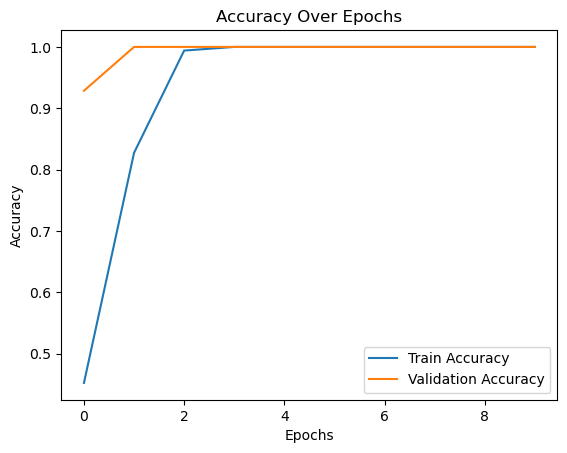

In [97]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


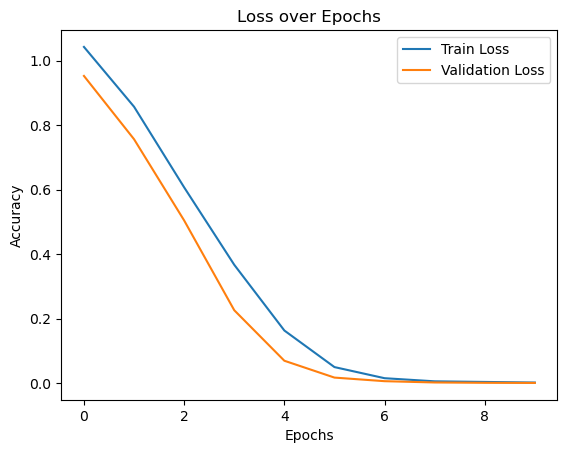

In [98]:
plt.plot(history.history['loss'],label = 'Train Loss')
plt.plot(history.history['val_loss'],label = 'Validation Loss')
plt.title("Loss over Epochs")
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# LSTM (Machine Translation)

## Step -1 Prepare the dataset

In [99]:
data = {
    "english": [
        "hello", "how are you", "thank you", "good morning", "good night",
        "see you later", "what is your name", "my name is John", "I am happy",
        "I love programming"
    ],
    "hindi": [
        "नमस्ते", "आप कैसे हैं", "धन्यवाद", "सुप्रभात", "शुभ रात्रि",
        "फिर मिलेंगे", "आपका नाम क्या है", "मेरा नाम जॉन है", "मैं खुश हूं",
        "मुझे प्रोग्रामिंग पसंद है"
    ]
}

# Convert the data to a DataFrame
df = pd.DataFrame(data)
df

,english,hindi
0,hello,नमस्ते
1,how are you,आप कैसे हैं
2,thank you,धन्यवाद
3,good morning,सुप्रभात
4,good night,शुभ रात्रि
5,see you later,फिर मिलेंगे
6,what is your name,आपका नाम क्या है
7,my name is John,मेरा नाम जॉन है
8,I am happy,मैं खुश हूं
9,I love programming,मुझे प्रोग्रामिंग पसंद है


In [100]:
df['hindi'] = df['hindi'].apply(lambda x:"<start>" + x + "<end>")
# just to make it to understand start and end of the sentence

In [101]:
df

,english,hindi
0,hello,<start>नमस्ते<end>
1,how are you,<start>आप कैसे हैं<end>
2,thank you,<start>धन्यवाद<end>
3,good morning,<start>सुप्रभात<end>
4,good night,<start>शुभ रात्रि<end>
5,see you later,<start>फिर मिलेंगे<end>
6,what is your name,<start>आपका नाम क्या है<end>
7,my name is John,<start>मेरा नाम जॉन है<end>
8,I am happy,<start>मैं खुश हूं<end>
9,I love programming,<start>मुझे प्रोग्रामिंग पसंद है<end>


## Step-2 Tokenize the sentences

In [102]:
max_vocab_size = 2000 # Limit vocabulary size for simplicity

In [103]:
# English Tokenize

tokenizer_eng = Tokenizer(num_words = max_vocab_size,filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower =True)  # 
tokenizer_eng.fit_on_texts(df['english'])
input_sequences = tokenizer_eng.texts_to_sequences(df['english'])
input_sequences

[[6],
 [7, 8, 1],
 [9, 1],
 [2, 10],
 [2, 11],
 [12, 1, 13],
 [14, 3, 15, 4],
 [16, 4, 3, 17],
 [5, 18, 19],
 [5, 20, 21]]

In [126]:
# Hindi sentence tokenize

tokenizer_hin = Tokenizer(num_words=max_vocab_size, filters='', lower=True)
tokenizer_hin.fit_on_texts(df['hindi'])

# Ensure <start> and <end> tokens are included
if '<start>' not in tokenizer_hin.word_index or '<end>' not in tokenizer_hin.word_index:
    tokenizer_hin.word_index['<start>'] = len(tokenizer_hin.word_index) + 1
    tokenizer_hin.word_index['<end>'] = len(tokenizer_hin.word_index) + 2
    
target_sequences = tokenizer_hin.texts_to_sequences(df['hindi'])
target_sequences

[[3],
 [4, 5, 6],
 [7],
 [8],
 [9, 10],
 [11, 12],
 [13, 2, 14, 1],
 [15, 2, 16, 1],
 [17, 18, 19],
 [20, 21, 22, 1]]

In [127]:
# Get word-to-index mapping
input_word_index = tokenizer_eng.word_index
target_word_index = tokenizer_hin.word_index
print(input_word_index)
print()
print(target_word_index)

{'you': 1, 'good': 2, 'is': 3, 'name': 4, 'i': 5, 'hello': 6, 'how': 7, 'are': 8, 'thank': 9, 'morning': 10, 'night': 11, 'see': 12, 'later': 13, 'what': 14, 'your': 15, 'my': 16, 'john': 17, 'am': 18, 'happy': 19, 'love': 20, 'programming': 21}

{'है<end>': 1, 'नाम': 2, '<start>नमस्ते<end>': 3, '<start>आप': 4, 'कैसे': 5, 'हैं<end>': 6, '<start>धन्यवाद<end>': 7, '<start>सुप्रभात<end>': 8, '<start>शुभ': 9, 'रात्रि<end>': 10, '<start>फिर': 11, 'मिलेंगे<end>': 12, '<start>आपका': 13, 'क्या': 14, '<start>मेरा': 15, 'जॉन': 16, '<start>मैं': 17, 'खुश': 18, 'हूं<end>': 19, '<start>मुझे': 20, 'प्रोग्रामिंग': 21, 'पसंद': 22, '<start>': 23, '<end>': 25}


In [128]:
# pad sequences

max_input_length= max(len(seq) for seq in input_sequences)
max_target_length = max(len(seq) for seq in target_sequences)
print(max_input_length,max_target_length)

4 4


In [129]:
encoder_input_data = pad_sequences(input_sequences,maxlen =max_input_length,padding ='post')
decoder_input_data = pad_sequences(target_sequences,maxlen = max_target_length, padding = 'post')
print(encoder_input_data)
print()
print(decoder_input_data)

[[ 6  0  0  0]
 [ 7  8  1  0]
 [ 9  1  0  0]
 [ 2 10  0  0]
 [ 2 11  0  0]
 [12  1 13  0]
 [14  3 15  4]
 [16  4  3 17]
 [ 5 18 19  0]
 [ 5 20 21  0]]

[[ 3  0  0  0]
 [ 4  5  6  0]
 [ 7  0  0  0]
 [ 8  0  0  0]
 [ 9 10  0  0]
 [11 12  0  0]
 [13  2 14  1]
 [15  2 16  1]
 [17 18 19  0]
 [20 21 22  1]]


In [130]:
decoder_output_data = np.zeros((len(target_sequences),max_target_length,len(target_word_index)+1),dtype = 'float32')
decoder_output_data
# each sequence is one array(10 sentences)
# vocab size = no of zeros(21+1)
# max length = no of rows in each array(4) 

array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [131]:
for i,seq in enumerate(target_sequences):
    for t,word_index in enumerate(seq[1:]):  # skip the start token
        decoder_output_data[i,t,word_index] = 1.0   # one hot encoding

## Step -3 Build the Seq2Seq Model

### encoder

In [132]:
from tensorflow.keras.layers import Input

encoder_inputs = Input(shape = (max_input_length,))     # creating a tuple(,)
encoder_embedding = Embedding(input_dim = len(input_word_index)+1,output_dim = 256)(encoder_inputs)
encoder_lstm,state_h,state_c = LSTM(256,return_state = True)(encoder_embedding)
encoder_states = [state_h,state_c]

### Decoder

In [133]:
decoder_inputs = Input(shape = (max_target_length,))
decoder_embedding = Embedding(input_dim = len(target_word_index)+1,output_dim = 256)(decoder_inputs)
decoder_lstm = LSTM(256,return_sequences = True,return_state = True)
decoder_outputs,_,_ = decoder_lstm(decoder_embedding,initial_state = encoder_states)
decoder_dense = Dense(len(target_word_index)+1,activation = 'softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [134]:
from tensorflow.keras.models import Model
model = Model([encoder_inputs,decoder_inputs],decoder_outputs)

In [135]:
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [136]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 4, 256)       5632        ['input_5[0][0]']                
                                                                                                  
 embedding_4 (Embedding)        (None, 4, 256)       6400        ['input_6[0][0]']                
                                                                                            

### Step-4 Train the Model

In [137]:
x_train,x_test,y_train,y_test,dec_train,dec_test = train_test_split(encoder_input_data,
                            decoder_output_data,decoder_input_data,test_size =0.2,random_state =42)

In [138]:
model.fit([x_train,dec_train],y_train,batch_size =16,epochs = 20,validation_split =0.2)

Epoch 1/20
1/1 [==============================] - 13s 13s/step - loss: 1.0730 - accuracy: 0.0000e+00 - val_loss: 1.2011 - val_accuracy: 0.2500
Epoch 2/20
1/1 [==============================] - 0s 150ms/step - loss: 1.0630 - accuracy: 0.2500 - val_loss: 1.1979 - val_accuracy: 0.2500
Epoch 3/20
1/1 [==============================] - 0s 128ms/step - loss: 1.0527 - accuracy: 0.2500 - val_loss: 1.1943 - val_accuracy: 0.2500
Epoch 4/20
1/1 [==============================] - 0s 155ms/step - loss: 1.0418 - accuracy: 0.2500 - val_loss: 1.1903 - val_accuracy: 0.2500
Epoch 5/20
1/1 [==============================] - 0s 150ms/step - loss: 1.0300 - accuracy: 0.2500 - val_loss: 1.1858 - val_accuracy: 0.2500
Epoch 6/20
1/1 [==============================] - 0s 132ms/step - loss: 1.0170 - accuracy: 0.2500 - val_loss: 1.1807 - val_accuracy: 0.2500
Epoch 7/20
1/1 [==============================] - 0s 142ms/step - loss: 1.0025 - accuracy: 0.2500 - val_loss: 1.1748 - val_accuracy: 0.2500
Epoch 8/20
1/1 [=

### Step -5 Inference Model for Testing

In [139]:
# Define Encoder Model for Inference
encoder_model = Model(encoder_inputs,encoder_states)

# encoder_states -represents output states of the encoder, which usually include the hidden state and cell state (if using LSTM) after processing the input sequences.

In [140]:
# Define Decoder Model for Inference
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h,decoder_state_input_c]


In [141]:
decoder_lstm_output,state_h,state_c = decoder_lstm(decoder_embedding,initial_state = decoder_states_inputs)

#decoder_lstm_output - output is typically a sequence of predictions (e.g., probabilities for each word in the vocabulary at each time step
# state_h - hidden state output from the LSTM after processing the input
# state_c - variable holds the cell state output from the LSTM. Similar to state_h, it carries information about long-term dependencies.

In [142]:
decoder_states = [state_h,state_c]
decoder_outputs = decoder_dense(decoder_lstm_output)

In [143]:
decoder_model = Model([decoder_inputs] + decoder_states_inputs,[decoder_outputs] + decoder_states)

## Step 6 - Translation Function

In [146]:
def decode_sequence(input_seq):
    # Encode the input sequence to get the context vector
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence with the <start> token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_word_index['<start>']

    # Generate translation iteratively
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Get the predicted word index with the highest probability
        predicted_word_index = np.argmax(output_tokens[0, -1, :])
        predicted_word = tokenizer_hin.index_word.get(predicted_word_index, '')

        if predicted_word == '<end>' or len(decoded_sentence.split()) > max_target_length:
            stop_condition = True
        else:
            decoded_sentence += ' ' + predicted_word

        # Update target sequence and states for the next iteration
        target_seq[0, 0] = predicted_word_index
        states_value = [h, c]

    return decoded_sentence.strip()


## Step 7 Test the Translation

In [147]:
for seq_index in range(5):
    input_seq = encoder_input_data[seq_index:seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(f"Input sentence: {df['english'][seq_index]}")
    print(f"Translated sentence: {decoded_sentence}")
    print()

1/1 [==============================] - 0s 65ms/step
Input sentence: hello
Translated sentence: रात्रि<end> रात्रि<end> रात्रि<end> रात्रि<end> रात्रि<end>

1/1 [==============================] - 0s 60ms/step
Input sentence: how are you
Translated sentence: रात्रि<end> रात्रि<end> है<end> है<end> रात्रि<end>

1/1 [==============================] - 0s 76ms/step
Input sentence: thank you
Translated sentence: रात्रि<end> रात्रि<end> रात्रि<end> रात्रि<end> रात्रि<end>

1/1 [==============================] - 0s 68ms/step
Input sentence: good morning
Translated sentence: रात्रि<end> रात्रि<end> रात्रि<end> रात्रि<end> रात्रि<end>

1/1 [==============================] - 0s 63ms/step
Input sentence: good night
Translated sentence: रात्रि<end> रात्रि<end> रात्रि<end> रात्रि<end> रात्रि<end>



In [ ]:
# Errors may be of Insufficient Training Data: The dataset is too small to learn meaningful translations.